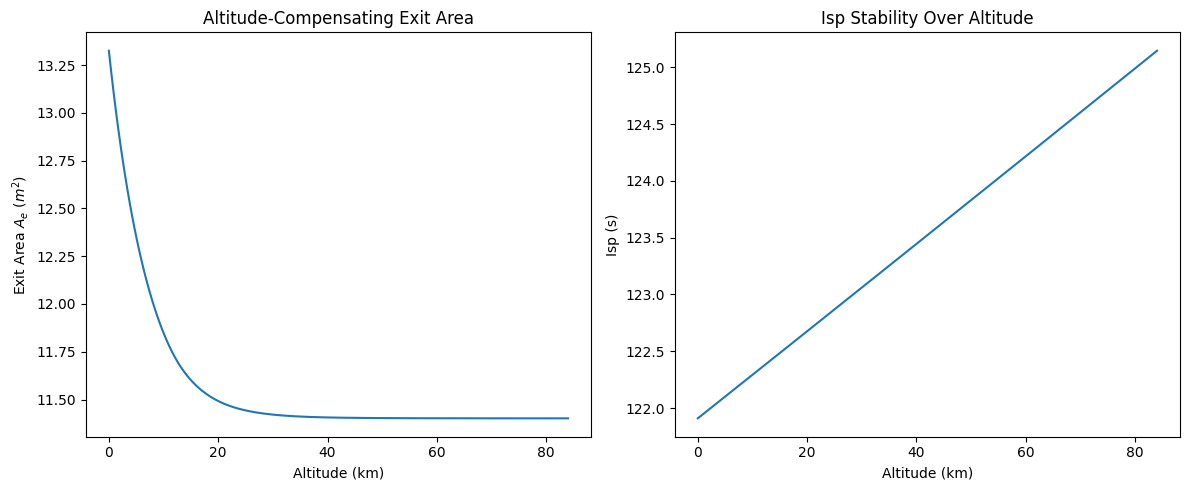

In [23]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from atmosphere import grid_profile
from scipy.optimize import root_scalar

gas = ct.Solution('gri30.yaml')
n = 200
fuel = 'H2:2'
ox = 'O2:1'
g0 = 9.807
F = 8e6
#Phi Related
nphis = n
phis = np.linspace(0.6, 5, nphis)
T0 = np.zeros(nphis)
gamma = np.zeros(nphis)
Rspec = np.zeros(nphis)
rho0 = np.zeros(nphis)
OFact = np.zeros(nphis)
Tt = np.zeros(nphis)
rhot = np.zeros(nphis)
at = np.zeros(nphis)
#Epsilon Related
nepsilon = n
epsilons = np.linspace(10, 50, nepsilon)
ve = np.zeros((nphis, nepsilon))
Te = np.zeros((nphis, nepsilon))
Me = np.zeros((nphis, nepsilon))
ae = np.zeros((nphis, nepsilon))
#Pressure Related
natm = n
atm = grid_profile(n=natm, h_min=0, h_max=84000)
gatm = atm['g']
Patm = atm['P']
P0 = 7e6
Pe = np.zeros((nphis, nepsilon))
Isp = np.zeros((nphis, nepsilon, natm))
At = np.zeros((nphis, nepsilon, natm))
Ae = np.zeros((nphis, nepsilon, natm))
Lstar = np.zeros((nphis, nepsilon, natm))

from scipy.optimize import root_scalar

def area_ratio(Me, gamma):
    term = (2/(gamma+1)) * (1 + (gamma-1)/2 * Me**2)
    exponent = (gamma+1)/(2*(gamma-1))
    return (1/Me) * term**exponent

def solve_Me_from_eps(epsilon, gamma):
    # Residual function: f(Me) = area_ratio(Me, gamma) - epsilon
    def residual(Me):
        return area_ratio(Me, gamma) - epsilon

    # Solve using Brent's method with bracketed guess (Mach > 1)
    sol = root_scalar(residual, bracket=[1.01, 50.0], method='brentq', xtol=1e-6, rtol=1e-8)

    if not sol.converged:
        raise RuntimeError(f"Mach solve failed for ε={epsilon:.2f}, γ={gamma:.3f}")
    
    return sol.root


for i, phi in enumerate(phis):
    gas.set_equivalence_ratio(phi = phi, fuel=fuel, oxidizer=ox)
    gas.TP = 298.15, P0
    gas.equilibrate('HP')
    cp = gas.cp_mass
    cv = gas.cv_mass
    gamma_i = cp / cv
    gamma[i] = gamma_i
    T0_i = gas.T
    T0[i] = T0_i
    phis[i] = phi
    R_i = cp - cv
    Rspec[i] = R_i
    rho0_i = gas.density_mass
    rho0[i] = rho0_i
    Tt_i = T0_i*(2/(gamma_i+1))
    Tt[i] = Tt_i
    rhot_i = rho0_i*((2/(gamma_i+1))**(1/(gamma_i+1)))
    rhot[i] = rhot_i
    at_i = np.sqrt(gamma_i*R_i*Tt_i)
    at[i] = at_i
    for j, epsilon in enumerate(epsilons):
        Me_ij = solve_Me_from_eps(epsilon, gamma_i)
        Me[i,j] = Me_ij
        Pe_ij= P0*(1 + ((gamma_i+1)/2)*(Me_ij)**2)**(-gamma_i/(gamma_i-1))
        Pe[i,j] = Pe_ij
        Te_ij = T0_i/((P0/Pe_ij)**((gamma_i-1)/gamma_i))
        Te[i,j] = Te_ij
        ae_ij = np.sqrt(gamma_i*R_i*Te_ij)
        ae[i,j] = ae_ij
        ve_ij = Me_ij*ae_ij
        ve[i,j] = ve_ij
        for k, Pb in enumerate(Patm):
            gatm_k = gatm[k]
            Isp_ijk = ve_ij/gatm_k
            Isp[i,j,k] = Isp_ijk
            At_ijk = F/(rhot_i*at_i*Isp_ijk*gatm_k+(Pe_ij-Pb)*epsilon)
            At[i,j,k] = At_ijk
            Ae_ijk = epsilon * At_ijk
            Ae[i,j,k]= Ae_ijk
            Lstar_ijk = 1/(rho0_i*At_ijk)
            Lstar[i,j,k] = Lstar_ijk


OFsto = gas.stoich_air_fuel_ratio('H2:2', 'O2:1')
OFact = OFsto/phis

# Store all standard deviations
pillar_std = np.zeros((nphis, nepsilon))

for i in range(nphis):
    for j in range(nepsilon):
        pillar_std[i, j] = np.std(Isp[i, j, :])

# Find (i*, j*) of the pillar with least std dev over altitude
best_i, best_j = np.unravel_index(np.argmin(pillar_std), pillar_std.shape)

# Extract key data
best_phi = phis[best_i]
best_OF = OFsto / best_phi
best_eps = epsilons[best_j]
isp_base = Isp[best_i, best_j, 0]
at_base = At[best_i, best_j, 0]
Ae_profile = Ae[best_i, best_j, :]
Isp_profile = Isp[best_i, best_j, :]

alt_km = np.linspace(0, 84, natm)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(alt_km, Ae_profile)
plt.xlabel("Altitude (km)")
plt.ylabel("Exit Area $A_e$ ($m^2$)")
plt.title("Altitude-Compensating Exit Area")

plt.subplot(1, 2, 2)
plt.plot(alt_km, Isp_profile)
plt.xlabel("Altitude (km)")
plt.ylabel("Isp (s)")
plt.title("Isp Stability Over Altitude")

plt.tight_layout()
plt.show()

